## Exercise

Load the national COVID dataset and solve the exercise using `scikit-learn` library.
Consider first the column corresponding to the (cumulative) number of deaths. 
1. Perform a train-test split, with observations from the last week corresponding to the test set;
2. Build a suitable combination of kernels choosing from the ones shown in `notebook_05`;
3. Fit a `GaussianProcessRegressor` to predict the daily number of swabs, plot future predictions and compare them to real test data;
4. Repeat points 1-3 on the daily number of swabs, which can be computed from the cumulative number provided in the dataset.

You are welcome to try out and fit other data streams in the dataset. 


### Solution

We will use the [national data from Protezione Civile](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv).

Let's start by looking at the raw data and performing some basic cleanup to concentrate on the data of interest, more specifically:
1. Time data (date format and incremental day count from the first entry)
2. Cumulative deceased count
3. Daily number of swabs collected

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
#load raw data and take a peek at it
data_covid = pd.read_csv(os.path.join( "data", "dpc-covid19-ita-andamento-nazionale.csv")) 
data_covid.info()
data_covid

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   data                        75 non-null     object 
 1   stato                       75 non-null     object 
 2   ricoverati_con_sintomi      75 non-null     int64  
 3   terapia_intensiva           75 non-null     int64  
 4   totale_ospedalizzati        75 non-null     int64  
 5   isolamento_domiciliare      75 non-null     int64  
 6   totale_positivi             75 non-null     int64  
 7   variazione_totale_positivi  75 non-null     int64  
 8   nuovi_positivi              75 non-null     int64  
 9   dimessi_guariti             75 non-null     int64  
 10  deceduti                    75 non-null     int64  
 11  totale_casi                 75 non-null     int64  
 12  tamponi                     75 non-null     int64  
 13  casi_testati                20 non-nu

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2020-05-04T17:00:00,ITA,16823,1479,18302,81678,99980,-199,1221,82879,29079,211938,2191403,1479910.0,dc-IT-0019,dc-EN-0019
71,2020-05-05T17:00:00,ITA,16270,1427,17697,80770,98467,-1513,1075,85231,29315,213013,2246666,1512121.0,NaN,NaN
72,2020-05-06T17:00:00,ITA,15769,1333,17102,74426,91528,-6939,1444,93245,29684,214457,2310929,1549892.0,dc-IT-0021,dc-EN-0021
73,2020-05-07T17:00:00,ITA,15174,1311,16485,73139,89624,-1904,1401,96276,29958,215858,2381288,1563557.0,dc-IT-0023,dc-EN-0023


We can get rid of most of the columns.
We'll also reformat dates and compute normalized deceased and swabs streams for later fitting.

In [3]:
#Data cleaning

#datetime as dataframe index
data_covid.index = pd.to_datetime(data_covid["data"])
data_covid.index = data_covid.index.date

#keep only columns of interest
data_covid=data_covid.loc[:,["deceduti","tamponi"]]

#normalized t axis (days from first entry)
data_covid["t"] = (data_covid.index - data_covid.index[0])/pd.Timedelta(1,"D")

#incremental swabs count
swabs = np.array(data_covid["tamponi"])
swabs[1:] = swabs[1:] - swabs[:-1]
data_covid["tamponi_incr"] = swabs/np.std(swabs)

#normalize deceased
data_covid["deceased"] = data_covid["deceduti"]/np.std(data_covid["deceduti"])

#see results
data_covid.info()
data_covid

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 2020-02-24 to 2020-05-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   deceduti      75 non-null     int64  
 1   tamponi       75 non-null     int64  
 2   t             75 non-null     float64
 3   tamponi_incr  75 non-null     float64
 4   deceased      75 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 3.5+ KB


,deceduti,tamponi,t,tamponi_incr,deceased
2020-02-24,7,4324,0.0,0.195890,0.000639
2020-02-25,10,8623,1.0,0.194757,0.000913
2020-02-26,12,9587,2.0,0.043672,0.001096
2020-02-27,17,12014,3.0,0.109950,0.001553
2020-02-28,21,15695,4.0,0.166760,0.001918
...,...,...,...,...,...
2020-05-04,29079,2191403,70.0,1.704794,2.656234
2020-05-05,29315,2246666,71.0,2.503575,2.677792
2020-05-06,29684,2310929,72.0,2.911301,2.711498
2020-05-07,29958,2381288,73.0,3.187468,2.736527


Let's plot the data we're going to attempt to model.

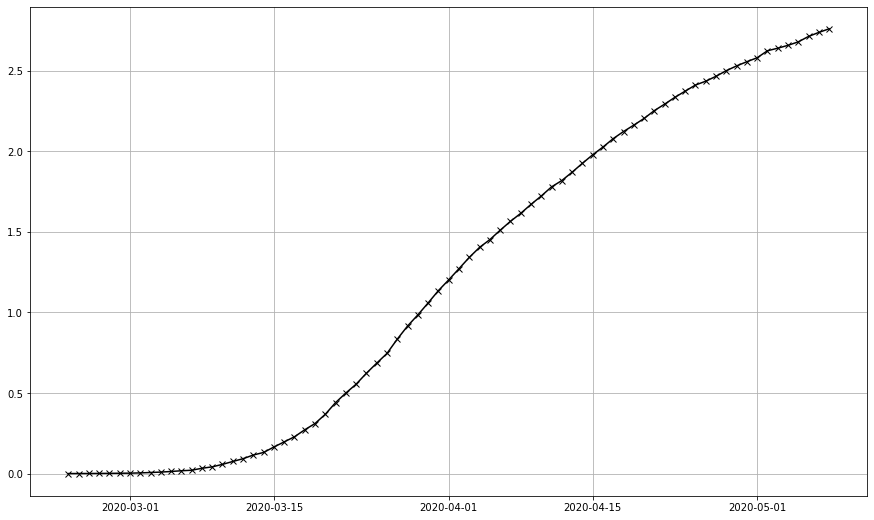

In [4]:
#raw deceased plot
plt.figure(figsize=(15,9))
plt.plot(data_covid.loc[:,"deceased"],'k')
plt.plot(data_covid.loc[:,"deceased"], 'xk')

plt.grid()

The cumulative deceased count curve shows a rather smooth trend with a somewhat sigmoidal flavour. Let's look at the relative increments to better inspect if there's some sign of regularity hidden in the small bumps:

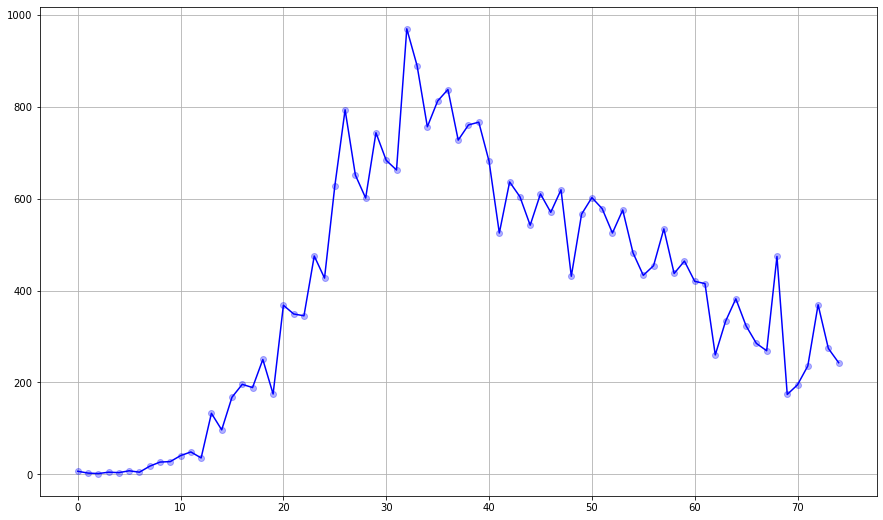

In [5]:
#incremental swabs count
d = np.array(data_covid["deceduti"])
d[1:] = d[1:] - d[:-1]
d = d

plt.figure(figsize=(15,9))
plt.plot(d,'b')
plt.plot(d, 'ob', alpha=.3)

plt.grid()

as far as a quick eye exam can tell, the bumpiness doesn't follow a regular trend.
Let's now look at the daily swab count:

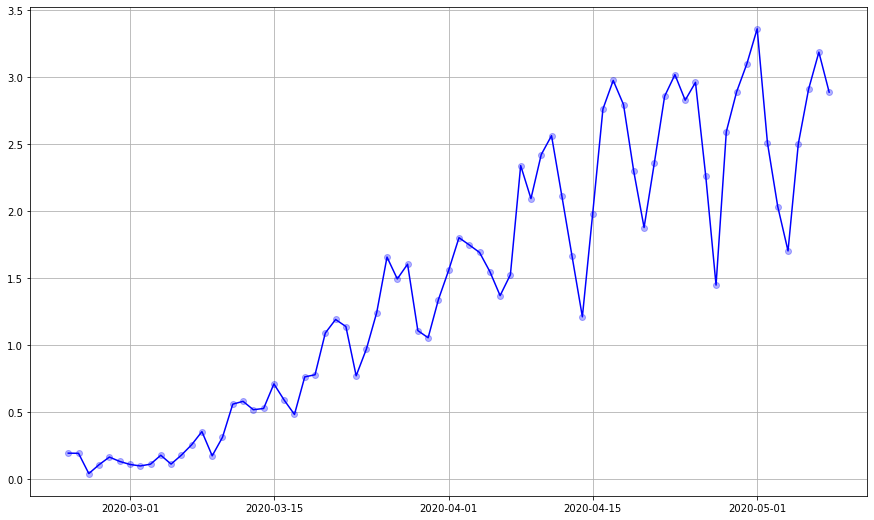

In [6]:
# raw swabs plot
plt.figure(figsize=(15,9))
plt.plot(data_covid.loc[:,"tamponi_incr"],'b')
plt.plot(data_covid.loc[:,"tamponi_incr"], 'ob', alpha=.3)

plt.grid()

We can eyeball an increasingly marked weekly oscillation superimposing a low frequency increasing trend. This is likely due to the higher influence of the human factor (indeed sundays and mondays consistently present local minima). We can immediately tell that fitting this signal will require more kernel trickery.

We will now define a GP to fit the cumulative deceased count. We will use the data until Sunday 2020/04/26 as train set and predict the values for the remaining days.

In [7]:
# get train/test values
idx_test_start = pd.to_datetime("2020/04/27")
x_deceased_full = np.array(data_covid["t"])
x_deceased_train = np.array(data_covid.loc[:idx_test_start,"t"])
x_deceased_test = np.array(data_covid.loc[idx_test_start:,"t"])

y_deceased_full = np.array(data_covid["deceased"])
y_deceased_train = np.array(data_covid.loc[:idx_test_start,"deceased"])
y_deceased_test = np.array(data_covid.loc[idx_test_start:,"deceased"])

In [8]:
# Import required GP libaries
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [9]:
#setup kernel
ker_deceased0 = 10**2 * RBF(length_scale=50) + WhiteKernel(noise_level=.1)


gp_deceased = GaussianProcessRegressor(kernel = ker_deceased0,
                                       normalize_y=True,
                                       alpha=0.1,
                                       n_restarts_optimizer=3)
gp_deceased

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=10**2 * RBF(length_scale=50) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=3, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [10]:
#fit and print trained kernel
gp_deceased.fit(x_deceased_train[:,None],y_deceased_train)
gp_deceased.kernel_

1.11**2 * RBF(length_scale=32) + WhiteKernel(noise_level=1e-05)

In [11]:
gp_deceased.log_marginal_likelihood_value_

4.7990766396071365

[  0.20253497   3.46499941 -11.51292546]


Text(0.5, 1.0, 'Log marginal likelihood')

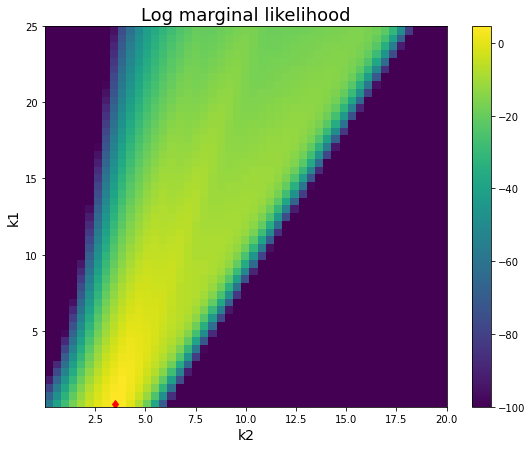

In [12]:
print(gp_deceased.kernel_.theta)
theta3_ML = gp_deceased.kernel_.theta[2]
# The GP also exposes the log marginal likelihood function callable
k1 = np.linspace(1e-3, 25, 50)
k2 = np.linspace(1e-3, 20, 50)
lml = np.empty((len(k1), len(k2)))
for i, k1_ in enumerate(k1):
    for j, k2_ in enumerate(k2):
        try:
            lml[i, j] = gp_deceased.log_marginal_likelihood([k1_, k2_, theta3_ML])
        except ValueError:
            lml[i, j] = np.nan
plt.figure(figsize=(9, 7))
plt.pcolor(k2, k1, lml,
           vmin=-100)
plt.colorbar()
plt.plot([gp_deceased.kernel_.theta[1]], [gp_deceased.kernel_.theta[0]],
         'dr')
plt.xlabel('k2', fontsize=14)
plt.ylabel('k1', fontsize=14)
plt.title('Log marginal likelihood', fontsize=18)

In [13]:
gp_deceased.get_params()

{'alpha': 0.1,
 'copy_X_train': True,
 'kernel__k1': 10**2 * RBF(length_scale=50),
 'kernel__k2': WhiteKernel(noise_level=0.1),
 'kernel__k1__k1': 10**2,
 'kernel__k1__k2': RBF(length_scale=50),
 'kernel__k1__k1__constant_value': 100,
 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k1__k2__length_scale': 50,
 'kernel__k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'kernel__k2__noise_level': 0.1,
 'kernel__k2__noise_level_bounds': (1e-05, 100000.0),
 'kernel': 10**2 * RBF(length_scale=50) + WhiteKernel(noise_level=0.1),
 'n_restarts_optimizer': 3,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [14]:
# predict the new values
y_deceased_predict, y_std_deceased_predict = gp_deceased.predict(x_deceased_full[:,None],return_std=True)

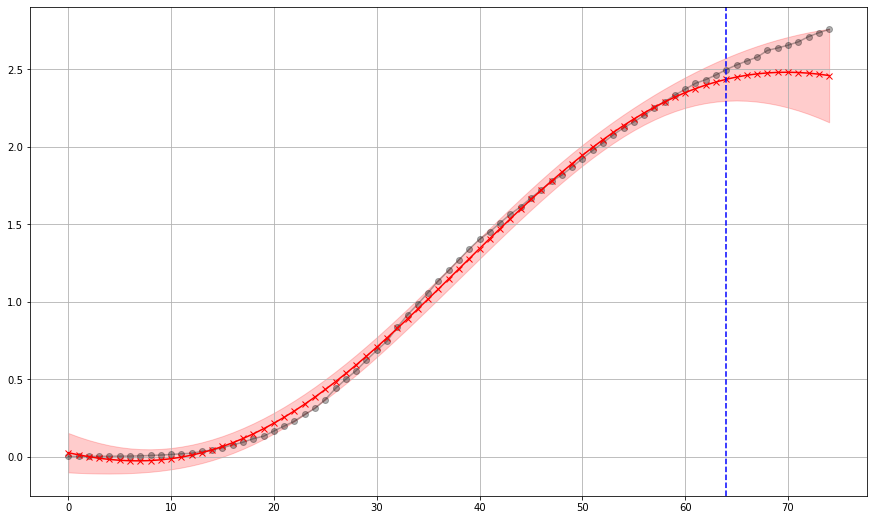

In [15]:
# plot predictions
plt.figure(figsize=(15,9))
plt.plot(x_deceased_full,y_deceased_full, 'k',alpha=.3)
plt.plot(x_deceased_full,y_deceased_full, 'ok',alpha=.3)

plt.plot(x_deceased_full,y_deceased_predict, 'r')
plt.plot(x_deceased_full,y_deceased_predict, 'xr')
plt.fill_between(x_deceased_full,
                 y_deceased_predict - y_std_deceased_predict,
                 y_deceased_predict + y_std_deceased_predict,
                     color='r', alpha=0.2)
plt.axvline(data_covid.iloc[len(data_covid.loc[:idx_test_start,])]["t"],
            color="blue", linestyle="--")
plt.grid()

We used a mixture of an RBF kernel and white noise to model the data, as adding further terms didn't show any benefit to the final fit. The quality of the prediction is not excellent, even though the real data falls within the 1-sigma interval.

Let's now try modeling the daily swab count, using the same time intervals to determine train and test sets.

In [16]:
# get train/test values
x_swabs_full = np.array(data_covid["t"])
x_swabs_train = np.array(data_covid.loc[:idx_test_start,"t"])

y_swabs_full = np.array(data_covid["tamponi_incr"])
y_swabs_train = np.array(data_covid.loc[:idx_test_start,"tamponi_incr"])

In [17]:
#setup kernel
ker_swabs0 = 10**2 * RBF(length_scale=50) + WhiteKernel(noise_level=2) +\
             10**2 * RBF(length_scale=50) *  ExpSineSquared(length_scale=10, periodicity=7.0,
                     periodicity_bounds="fixed")

gp_swabs = GaussianProcessRegressor(kernel = ker_swabs0,
                                       normalize_y=True,
                                       alpha=0.1,
                                       n_restarts_optimizer=3)
gp_swabs

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=10**2 * RBF(length_scale=50) + WhiteKernel(noise_level=2) + 10**2 * RBF(length_scale=50) * ExpSineSquared(length_scale=10, periodicity=7),
                         n_restarts_optimizer=3, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [18]:
#fit
gp_swabs.fit(x_swabs_train[:,None],y_swabs_train)
gp_swabs.kernel_

0.00316**2 * RBF(length_scale=35.9) + WhiteKernel(noise_level=1e-05) + 1.23**2 * RBF(length_scale=37.9) * ExpSineSquared(length_scale=4.28, periodicity=7)

In [19]:
gp_swabs.log_marginal_likelihood_value_

-12.267754658843351

In [20]:
# predict the new values
y_swabs_predict, y_std_swabs_predict = gp_swabs.predict(x_swabs_full[:,None],return_std=True)

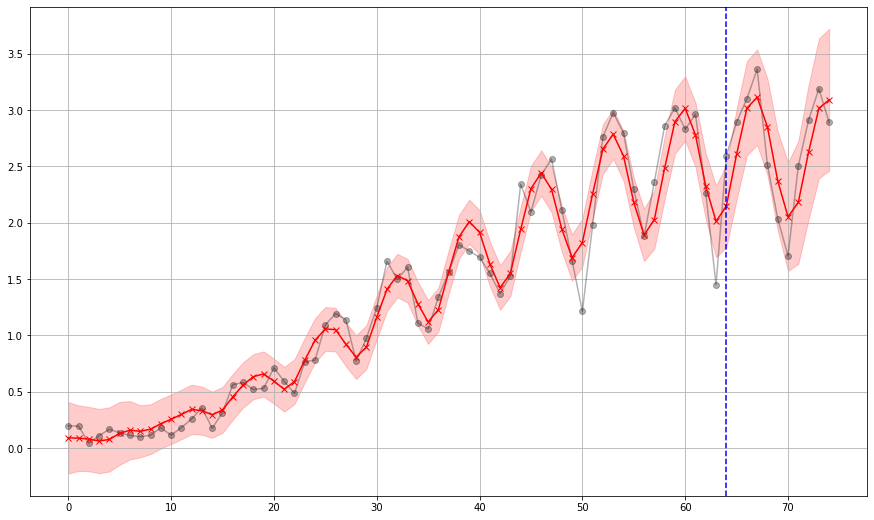

In [21]:
# plot predictions
plt.figure(figsize=(15,9))
plt.plot(x_swabs_full,y_swabs_full, 'k',alpha=.3)
plt.plot(x_swabs_full,y_swabs_full, 'ok',alpha=.3)

plt.plot(x_swabs_full,y_swabs_predict, 'r')
plt.plot(x_swabs_full,y_swabs_predict, 'xr')
plt.fill_between(x_swabs_full,
                 y_swabs_predict - 2*y_std_swabs_predict,
                 y_swabs_predict + 2*y_std_swabs_predict,
                     color='r', alpha=0.2)
plt.axvline(data_covid.iloc[len(data_covid.loc[:idx_test_start,])]["t"],
            color="blue", linestyle="--")
plt.grid()

In this second case we used a combination of an RBF kernel to capture the low frequency component causing the rising trend and a product between RBF and an exponential sine kernel with a fixed period of 7 to capture the variation described previously, and finally adding in a white noise component (which has been largely penalized by the optimizer, as suggested by the final `noise_level` parameter's value).
In this case the red regions in the graph show the 2-sigma uncertainty region, which captures almost entirely the actual values for the daily swabs.  
Considering the irregularity of the original data, we can in fact consider ourself satisfied with the final fit.